In this notebook we explore the basic plasticity mechanism of interest: activity-dependent fast LTP of synapses from ECII onto CA3 pyramidal cells. However, we do not include any excitatory or inhibitory recurrence in the CA3 network.

# Potentiated vs. non-potentiated cell voltage response to ECII input

First we explore how different levels of input from ECII onto CA3 PCs affect the difference in excitabilities between cells with and without potentiated ECII-CA3 synapses.

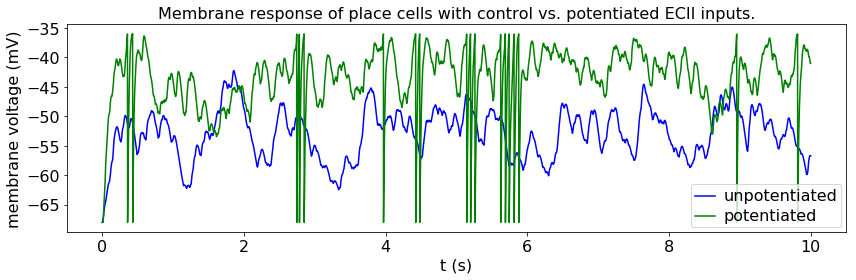

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
import plot

import PARAMETERS as P

DUR = 10
EC_RATE = 60

np.random.seed(0)

# generate upstream ECII spikes
ts = np.arange(0, DUR, P.DT)
spks_up = np.random.poisson(EC_RATE*P.DT, (len(ts), 2))

# make network with two cells, one receiving control ECII input and one receiving potentiated ECII input
N = 2
WS_RCR = {'NMDA': np.zeros((2, 2))}
WS_UP = {'NMDA': np.diag([P.W_N_EC_CA3_I, P.W_N_EC_CA3_F])}

ntwk = LIFNtwk(
    t_m=P.T_M,
    e_leak=P.E_LEAK,
    v_th=P.V_TH,
    v_reset=P.V_RESET,
    t_r=P.T_R,
    es_rev={'NMDA': P.E_NMDA},
    ts_syn={'NMDA': P.T_NMDA},
    ws_rcr=WS_RCR,
    ws_up=WS_UP,
)

vs_init = np.array([P.E_LEAK, P.E_LEAK])
gs_init = {'NMDA': np.array([0., 0])}
resp = ntwk.run(spks_up, vs_init, gs_init, P.DT)

# plot upstream spikes and each cell's membrane potential
fig, ax = plt.subplots(1, 1, figsize=(12, 4), tight_layout=True)

ax.plot(ts, 1000*resp.vs[:, 0], color='b')
ax.plot(ts, 1000*resp.vs[:, 1], color='g')

ax.set_xlabel('t (s)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('Membrane response of place cells with control vs. potentiated ECII inputs.')

ax.legend(['unpotentiated', 'potentiated'], loc='best')

plot.set_font_size(ax, 16)

This shows that as we expect, when a two CA3 PCs receive statistically identical ECII input, the one with potentiated synapses exhibits a higher membrane voltage and increased spike rate.

# CA3 ntwk response to running trajectory

### Place cell responses to a rat running through a box then pausing

In [2]:
%reset -f
%matplotlib inline
from IPython import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import os

from anim import build_frames, create_mp4, merge_frames
from aux import save_time_file
from ntwk import LIFNtwk
import plot
from traj import RandomTraj, InferredTraj, upstream_spks_from_traj

import PARAMETERS as P

# GENERAL PARAMS
SAVE_DIR = 'sims/plastic_basic'
BOX = (P.BOX_L, P.BOX_R, P.BOX_B, P.BOX_T)
DUR_RUN = 15
DUR_PAUSE = 15
DUR = DUR_RUN + DUR_PAUSE

ASPECT = (P.BOX_T - P.BOX_B) / (P.BOX_R - P.BOX_L)
FIG_SIZE = np.array([10, 10*ASPECT])

# TRAJ PARAMS
SEED = 2

XY_0 = (P.BOX_L, P.BOX_T)
V_0 = (.141, -.141)
T_CORR = 100

# NTWK PARAMS
N = 900
SYNS = ['AMPA', 'NMDA']

# upstream AMPA place-tuned cxns
W_UP_AMPA = np.concatenate(
    [P.W_A_PL_CA3 * np.eye(N), np.zeros((N, N))], axis=1)
# upstream NMDA cxns from ECII 
W_UP_NMDA = np.concatenate(
    [np.zeros((N, N)), P.W_N_EC_CA3_I * np.eye(N)], axis=1)

WS_UP = {'AMPA': W_UP_AMPA, 'NMDA': W_UP_NMDA}

NTWK_KWARGS = {
    't_m': P.T_M,  # (s)
    'e_leak': P.E_LEAK,  # (V)
    'v_th': P.V_TH,  # (V)
    'v_reset': P.V_RESET,  # (V)
    't_r': P.T_R,  # (s)
    'es_rev': {'AMPA': P.E_AMPA, 'NMDA': P.E_NMDA},  # (V)
    'ts_syn': {'AMPA': P.T_AMPA, 'NMDA': P.T_NMDA},  # (s)
    'ws_rcr': {'AMPA': np.zeros((N, N)), 'NMDA': np.zeros((N, N))},  # (unitless)
    'ws_up': WS_UP,
}

# PLASTICITY PARAMS
W_AMPA_PLASTIC = np.zeros(W_UP_AMPA.shape, dtype=bool)
W_NMDA_PLASTIC = np.concatenate([np.zeros((N, N)), np.eye(N)], axis=1).astype(bool)

MASKS_PLASTIC = {
    'AMPA': W_AMPA_PLASTIC,
    'NMDA': W_NMDA_PLASTIC,
}

PLASTICITY = {
    'masks': MASKS_PLASTIC,
    'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_EC_CA3_F},
    'T_W': P.T_W, 'T_C': P.T_C, 'C_S': P.C_S, 'BETA_C': P.BETA_C,
}

# EC INPUT PARAMS
EC_START = 20  # (s)
EC_END = 30  # (s)
EC_RATE = 60  # (Hz)

### Generate trajectory and place-tuned inputs

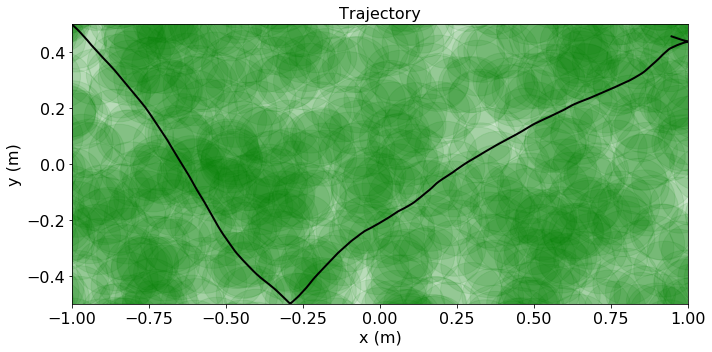

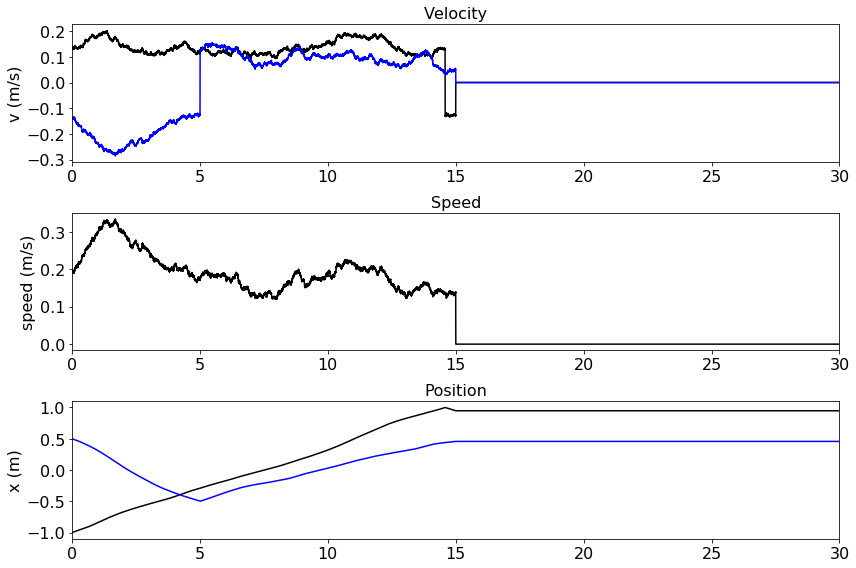

In [3]:
np.random.seed(SEED)

ts_run = np.arange(0, DUR_RUN, P.DT)
ts_pause = np.arange(DUR_RUN, DUR, P.DT)
ts = np.concatenate([ts_run, ts_pause])

traj = RandomTraj(ts_run, P.S_TRAJ, T_CORR, XY_0, V_0, BOX)
vs_pause = np.zeros((len(ts_pause), 2))
xys_pause = np.nan * np.zeros((len(ts_pause), 2))
xys_pause[:] = traj.xys[-1]

traj.xys = np.concatenate([traj.xys, xys_pause])
traj.vs = np.concatenate([traj.vs, vs_pause])

# place field ranges
pf_lb = [P.BOX_L - 0.1 * (P.BOX_R - P.BOX_L), P.BOX_B - 0.1 * (P.BOX_T - P.BOX_B)]
pf_ub = [P.BOX_R + 0.1 * (P.BOX_R - P.BOX_L), P.BOX_T + 0.1 * (P.BOX_T - P.BOX_B)]
centers = np.random.uniform(pf_lb, pf_ub, (N, 2)).T

stds = P.L_PL * np.ones(centers.shape[1])
max_rates = P.R_MAX_PL * np.ones(centers.shape[1])

time_file = save_time_file(os.path.join(SAVE_DIR, 'time.npy'), ts)
traj_file = traj.save(os.path.join(SAVE_DIR, 'traj.npy'))

# plot trajectory and place fields
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)

# trajectory
ax.plot(*traj.xys.T, lw=2, color='k')

# place fields
for center, std in zip(centers.T, stds):
    ell = Ellipse(center, width=std, height=std, angle=0, color='g', alpha=0.1)
    ax.add_artist(ell)
    
ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory')

plot.set_font_size(ax, 16)

fig, axs = plt.subplots(3, 1, figsize=(12, 8), tight_layout=True)

# velocity time-series
axs[0].plot(ts, traj.vs[:, 0], c='k')
axs[0].plot(ts, traj.vs[:, 1], c='b')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('v (m/s)')
axs[0].set_title('Velocity')

# speed time-series
speed = np.sqrt(traj.vs[:, 0]**2 + traj.vs[:, 1]**2)
axs[1].plot(ts, speed, c='k')
axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylabel('speed (m/s)')
axs[1].set_title('Speed')

# position time-series
axs[2].plot(ts, traj.xys[:, 0], c='k')
axs[2].plot(ts, traj.xys[:, 1], c='b')
axs[2].set_xlim(ts[0], ts[-1])
axs[2].set_ylabel('x (m)')
axs[2].set_title('Position')

for ax in axs:
    plot.set_font_size(ax, 16)

### Generate place-tuned inputs

In [4]:
spks_up_pl = upstream_spks_from_traj(ts, traj.xys, centers, stds, max_rates)

### Generate ECII inputs

In [5]:
spks_up_ec = np.zeros((len(ts), N), dtype=int)
spks_up_ec_mask = (ts >= EC_START) & (ts < EC_END)

spks_up_ec[spks_up_ec_mask, :] = np.random.poisson(
    EC_RATE*P.DT, (spks_up_ec_mask.sum(), N))

### Combine place-tuned and ECII inputs into full upstream input array

In [6]:
spks_up = np.concatenate([spks_up_pl, spks_up_ec], axis=1)

### Compute network response

In [7]:
# make ntwk and run simulation
ntwk = LIFNtwk(**NTWK_KWARGS, plasticity=PLASTICITY)
vs_init = P.E_LEAK * np.ones(N)
gs_init = {syn: np.zeros(N) for syn in SYNS}
resp = ntwk.run(spks_up, vs_init, gs_init, P.DT)
resp.place_field_centers = centers

ntwk_file = resp.save(os.path.join(SAVE_DIR, 'ntwk.npy'))

### Ntwk response raster plot

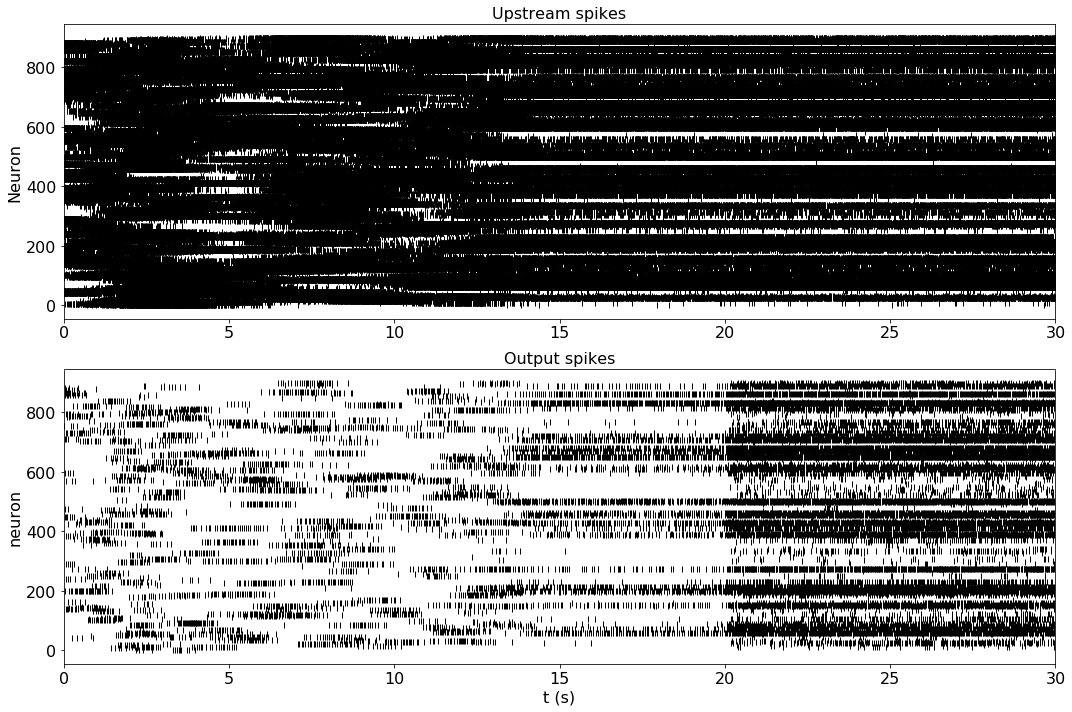

In [8]:
gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(15, 10), tight_layout=True)

axs = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, :]),
]

# raster plot of place-sensitive cell responses
spk_times_up = spks_up[:, :N].nonzero()[0] * P.DT

axs[0].scatter(spk_times_up, spks_up[:, :N].nonzero()[1], marker='|', lw=1, c='k')
axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylabel('Neuron')
axs[0].set_title('Upstream spikes')

plot.raster(
    axs[1],
    time_file,
    ntwk_file)

axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('neuron')
axs[1].set_title('Output spikes') 

for ax in axs:
    plot.set_font_size(ax, 16)

### EC-CA3 weight changes for most active and least active cells

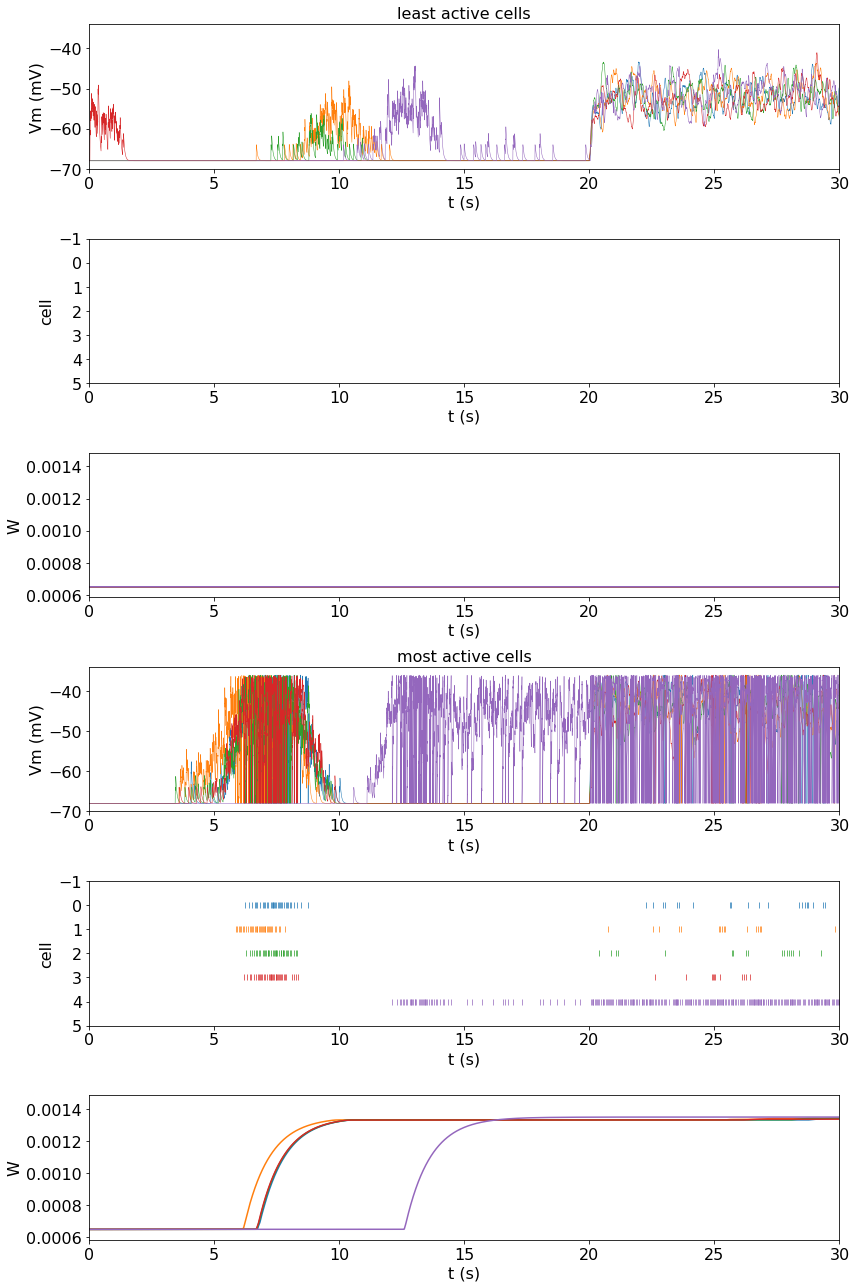

In [9]:
# find least and most active cells during running period
n_plot = 5

spk_cts_run = resp.spks[ts < DUR_RUN].sum(axis=0)
order = np.argsort(spk_cts_run)

least = order[:n_plot]
most = order[-n_plot:]

# get voltages, spikes, and EC-CA3 weights
vs_least = resp.vs[:, least]
vs_most = resp.vs[:, most]

spks_least = resp.spks[:, least]
spks_most = resp.spks[:, most]

ws_plastic_least = resp.ws_plastic['NMDA'][:, least]
ws_plastic_most = resp.ws_plastic['NMDA'][:, most]


# plot vs, spks, and ws_plastic for least and most active cell sets
fig, axs = plt.subplots(6, 1, figsize=(12, 18), tight_layout=True)

for ax_offset, title, vs, spks, ws_plastic in zip(
        [0, 3], ['least active cells', 'most active cells'],
        [vs_least, vs_most], [spks_least, spks_most],
        [ws_plastic_least, ws_plastic_most]):
    
    ax_vs = axs[ax_offset]
    ax_spks = axs[ax_offset+1]
    ax_ws = axs[ax_offset+2]
    
    # plot vs
    ax_vs.plot(ts, 1000*vs, lw=0.5)
    
    ax_vs.set_xlim(ts[0], ts[-1])
    ax_vs.set_ylim(-70, -34)
    ax_vs.set_xlabel('t (s)')
    ax_vs.set_ylabel('Vm (mV)')
    ax_vs.set_title(title)
    
    # plot spks
    for cell_ctr, spks_ in enumerate(spks.T):
        spk_ts = spks_.nonzero()[0] * P.DT
        ax_spks.scatter(spk_ts, cell_ctr*np.ones(spk_ts.shape), marker='|', lw=0.7)
        
    ax_spks.set_xlim(ts[0], ts[-1])
    ax_spks.set_ylim(n_plot, -1)
    ax_spks.set_xlabel('t (s)')
    ax_spks.set_ylabel('cell')
    
    # plot ws_plastic
    ax_ws.plot(ts, ws_plastic)
    
    ax_ws.set_xlim(ts[0], ts[-1])
    ax_ws.set_ylim(0.9*P.W_N_EC_CA3_I, 1.1*P.W_N_EC_CA3_F)
    ax_ws.set_xlabel('t (s)')
    ax_ws.set_ylabel('W')
    
for ax in axs:
    plot.set_font_size(ax, 16)

### Trajectory inferred from network activity

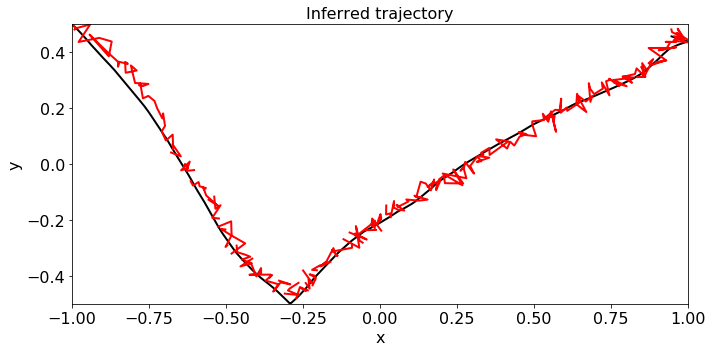

In [10]:
inferred = InferredTraj(
    ntwk_file=ntwk_file,
    time_file=time_file,
    window=0.05)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)
ax.plot(*traj.xys[ts < DUR_RUN].T, color='k', lw=2)
ax.plot(*inferred.xys[ts < DUR_RUN].T, color='r', lw=2)

ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_title('Inferred trajectory')

plot.set_font_size(ax, 16)

inferred_file = inferred.save(os.path.join(SAVE_DIR, 'inferred.npy'))

### Component frames for animation

In [11]:
frames_traj = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'traj/frame'),
    time_file=time_file,
    traj_file=traj_file,
    box=BOX,
    fps=60,
    title='Trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE,
    verbose=True)

In [12]:
frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(SAVE_DIR, 'ntwk/frame'),
    time_file=time_file,
    ntwk_file=ntwk_file,
    box=BOX,
    fps=60,
    resting_size=30,
    spk_size=350,
    amp=4,
    frames_per_spk=2,
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE)

In [13]:
frames_inferred = build_frames.traj(
    save_prefix=os.path.join(SAVE_DIR, 'inferred/frame'),
    time_file=time_file,
    traj_file=inferred_file,
    box=BOX,
    fps=60,
    location_size=200,
    location_color=(0, 0, 1),
    cov_cutoff=np.inf,
    title='Inferred trajectory',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.8*FIG_SIZE,
    verbose=True)

### Final (merged) frames

In [14]:
save_prefix = os.path.join(SAVE_DIR, 'merged/frame')
rects = [(0, 0, 1, 1), (1, 0, 2, 1), (0, 1, 1, 2)]
size = (2, 2)

frames_merged = merge_frames(
    [frames_traj, frames_ntwk, frames_inferred], save_prefix, rects, size)

### Final animation

In [16]:
movie = create_mp4(
    frames_merged, os.path.join(SAVE_DIR, 'full'), playback_fps=30, verbose=True)

Loading source images...
Source images loaded.
Generating movie and saving at "sims/plastic_basic/full.mp4"...
Movie generated.
